In [155]:
#fix weird branch stuff
#download libraries
%pip install Pillow
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [156]:
import tensorflow as tf
import os

In [157]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [158]:
print(tf.config.list_physical_devices('GPU'))

[]


In [159]:
import cv2
import imghdr

C:\Users\ds\AppData\Local\Temp\ipykernel_38892\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [160]:
data_dir = 'data' 

In [161]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [162]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\btd6\btd6_img.webp
Image not in ext list data\honkaistarrail\game-on_V_jpg--442x260-4g.webp
Image not in ext list data\honkaistarrail\Honkai-star-rail-combat-screen.jpg
Image not in ext list data\honkaistarrail\Honkai-Star-Rail-World-4-Take-Out-Piggies.jpg
Image not in ext list data\honkaistarrail\star-rail-blade-comps-header-07242023.png


In [163]:
#2 Load Data

import numpy as np
from matplotlib import pyplot as plt

In [164]:
#build data pipeline
data = tf.keras.utils.image_dataset_from_directory(folder_path)

Found 702 files belonging to 2 classes.


In [ ]:
#access generator from data pipeline
#data_iterator = data.as_numpy_iterator()

In [ ]:
#resizes image to fit the batch, 
#batch = data_iterator.next()

In [ ]:
#show array of league of legends, vs destiny (we can tell by the sample of images that league is 1 and destiny is 0)
#class 1 = league
#class 0 = destiny
#batch[0] is all the images
#batch[1] are labels
#batch[1]

In [165]:
#3 preprocess data
#applies the scaling while the data is being loaded
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [ ]:
batch[0].max()

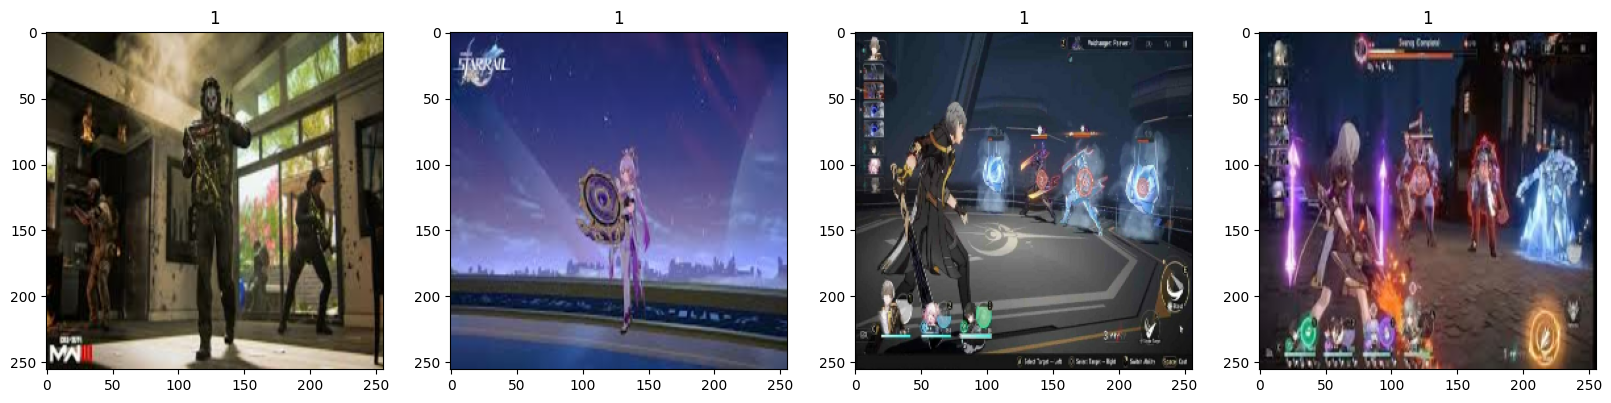

In [166]:
#visualize data with matplotlib
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [167]:
len(data)

22

In [168]:
#Split data into training, validation and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1)

In [169]:
#ensure that values add up into the length of the batches
train_size+val_size+test_size

22

In [170]:
#make sure data is shuffled before, in this case we already have shuffled the data with initial batch
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [171]:
#Sequential models great if you have one data input and one data output
#functional api is better if you have multiple inputs and multiple outputs
from tensorflow.keras.models import Sequential

#Conv2d is a 2d convolution layer (spatial convolution over images)
#maxpooling2d condenses all the values in a region and returns max
#Flatten turns convolution into a format that dense can understand
#dropout for regularization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [172]:
#Establish model
model = Sequential()

In [173]:
#add neural network layers
#scans layers to detect data, 16 filters, 3 by 3 filter, move by 1 pixel each time
#pass all data into relu function to modify the output data
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#return maximum value from the relu activation over a set region, reduce image data by half
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#condense rows and width, numbers of filters will form channel value but we don't want channel value so flatten removes that
#condenses into a single dimension (rows * width * filters)
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [174]:
#adam is a optimizer
#binary crossentropy losses are incorrect predictions? since we are determining numbers 0 and 1 from our final neural network layer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [175]:
#shows application of every layer and the 
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [176]:
#Train data

logdir ='logs'

In [177]:
#save the model at a certain state
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [178]:
#plot out data
#train : training data
#epochs : how long we train for, 1 epoch is 1 run through data
#validation_data : run evaluation on validation data
#ideally we want to see loss go down and accuracy go up
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.6101 - loss: 1.1526 - val_accuracy: 0.8625 - val_loss: 0.4752
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9069 - loss: 0.3174 - val_accuracy: 0.9438 - val_loss: 0.2287
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.9366 - loss: 0.2440 - val_accuracy: 0.9688 - val_loss: 0.1252
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.9667 - loss: 0.0863 - val_accuracy: 0.9563 - val_loss: 0.0894
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9746 - loss: 0.0720 - val_accuracy: 0.9812 - val_loss: 0.0444
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9915 - loss: 0.0376 - val_accuracy: 0.9875 - val_loss: 0.0287
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9962 - loss: 0.0176 - val_accuracy: 0.9812 - val_loss: 0.0236
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.9963 - loss: 0.0108 - val_accuracy: 1.

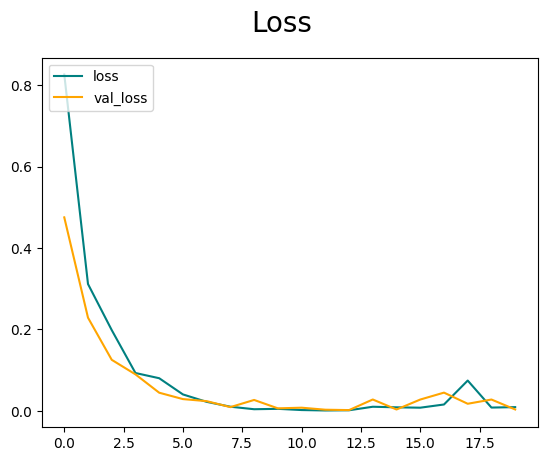

In [179]:
#plot performance

#plot loss metrics
fig = plt.figure()

#training loss is teal
plt.plot(hist.history['loss'], color='teal', label='loss')

#validation loss has orange color
#if val loss going up and loss going down it means model is overfitting, so apply regularization or change data
#if loss isn't decreasing at all, make a larger/sophisticated neural network or look again at training data
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

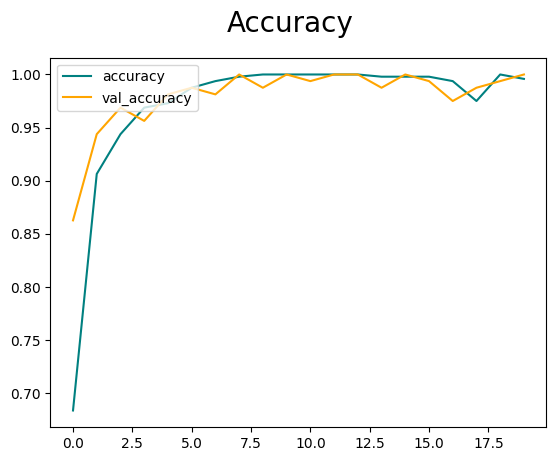

In [180]:
#visualize accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [181]:
#evaluate metrics
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [182]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [183]:
#run through each batch in testing data
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [184]:
#print result
#higher values ensure that model works better
print(f'Precision:{pre.result().numpy()}, Recall:{ re.result().numpy()}, Accuracy{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy1.0


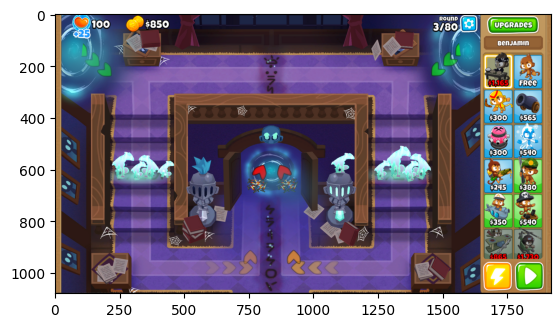

In [195]:
#test on new data
#uncomment lines below to test data
#img = cv2.imread('hsrt1.PNG')
img = cv2.imread('bloonst1.PNG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

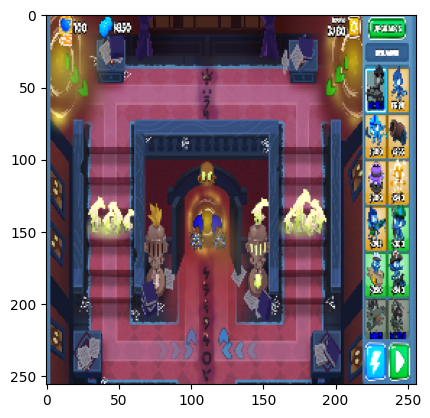

In [196]:
#resize image to throw into neural network
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [197]:
#throw into model
#put into list because model is taking batches and not taking singular lists
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [198]:
if yhat > 0.5: 
   print(f'Predicted class is honkai star rail')
else:
   print(f'Predicted class is bloons')

Predicted class is bloons


In [ ]:
#Save the model
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','gameidentifiermodel.h5'))

In [ ]:
#load the model
#new_model = load_model(os.path.join('models','gameidentifiermodel.h5'))